In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, UnivariateSpline, Rbf, make_interp_spline
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
import ffn
%matplotlib inline

: 

In [5]:
find_mask = lambda array : np.nonzero(array)[0]
DIS = lambda ground, inter : np.around(np.sum(np.abs(ground-inter)), decimals = 2)

def INTER(sdm, mask, func = interp1d):
    y_axis = np.delete(sdm, mask)
    interp_func = func(find_mask(~mask), y_axis)
    mask_val = interp_func(find_mask(mask))
    sdm[find_mask(mask)] = mask_val
    return np.around(sdm, decimals=2)

def LR(sdm, mask):
    y_axis = np.delete(sdm, mask)
    model = LinearRegression()
    model.fit(find_mask(~mask).reshape(-1, 1), y_axis)
    mask_val = model.predict(find_mask(mask).reshape(-1, 1))
    sdm[find_mask(mask)] = mask_val
    return np.around(sdm, decimals=2)

inter_func = {"interp1d": interp1d,
              "UnivariateSpline" : UnivariateSpline, 
              "Rbf" : Rbf, 
              "make_interp_spline" : make_interp_spline,
              "LinearRegression": None}


In [45]:
def get_res(day = 500, mask_percent = 0.2, inter_name=None, func = None):
    SD = pd.read_csv("../data/Stock/stock.csv", skiprows=[1],index_col=0)
    SD = SD[-day:]
    title = SD.columns
    SD = SD.to_numpy()
    SDM = SD.copy()

    MASK = np.random.choice([True, False], size=SDM.shape, p=[mask_percent, 1-mask_percent])
    MASK[0, :] = MASK[-1, :] = False
    SDM = np.ma.masked_array(SDM, mask=MASK)


    loss_queue = dict()
    for col, col_name in enumerate(title):
        if inter_name == "LinearRegression":
            inter_res = LR(SDM[:, col].copy(), MASK[:, col].copy())
        else:
            inter_res = INTER(SDM[:, col].copy(), MASK[:, col].copy(), func)
        inter_dis = DIS(SD[:, col], inter_res)
        return inter_dis/(day*mask_percent*np.mean(SD[:, col])/100)


In [46]:
output = dict()
def AVG(lst):
    return sum(lst)/len(lst)
for k1 in inter_func.keys():
    output[k1] = dict()
for day in tqdm(range(20, 100, 10)):

    avg = dict()
    for name in inter_func.keys():
        avg[name] = list()
    for _ in range(10):
        for k1, val1 in inter_func.items():
            ret = get_res(day=day,inter_name=k1, func=val1)
            avg[k1].append(ret)
    
    for name in inter_func.keys():
        output[name][day] = AVG(avg[name])
print(output)

100%|██████████| 8/8 [00:01<00:00,  5.40it/s]

{'interp1d': {20: 1.8154707862500523, 30: 1.8977453811783296, 40: 1.5718849221402043, 50: 1.8503775036759946, 60: 2.2326408181510558, 70: 1.420743071566786, 80: 1.7913376026088632, 90: 2.00292105402726}, 'UnivariateSpline': {20: 1.2303926361515791, 30: 1.7175231778028741, 40: 1.4855264878266892, 50: 1.4596046940988543, 60: 1.7407747034912624, 70: 1.963338191640623, 80: 2.1284532277838975, 90: 1.8955233623126913}, 'Rbf': {20: 1.4454974648359475, 30: 2.1107758370568095, 40: 1.9068265131692577, 50: 1.4317966533848356, 60: 2.598864096854647, 70: 2.126459719406027, 80: 2.5489628647710085, 90: 2.3805978369513334}, 'make_interp_spline': {20: 1.2562331512857399, 30: 2.155078137205451, 40: 1.6363712670154367, 50: 1.6275322458992665, 60: 2.6166191110795465, 70: 1.9982609873173236, 80: 2.2360797346327863, 90: 2.371282557581345}, 'LinearRegression': {20: 2.211459220873549, 30: 2.87485102375139, 40: 2.642245254725098, 50: 3.1053581904203207, 60: 4.6122304893281925, 70: 5.401496334888229, 80: 4.7957

In [47]:
df = pd.DataFrame(output)
# df = df.drop(columns=['LinearRegression'])
print(df)

    interp1d  UnivariateSpline       Rbf  make_interp_spline  LinearRegression
20  1.815471          1.230393  1.445497            1.256233          2.211459
30  1.897745          1.717523  2.110776            2.155078          2.874851
40  1.571885          1.485526  1.906827            1.636371          2.642245
50  1.850378          1.459605  1.431797            1.627532          3.105358
60  2.232641          1.740775  2.598864            2.616619          4.612230
70  1.420743          1.963338  2.126460            1.998261          5.401496
80  1.791338          2.128453  2.548963            2.236080          4.795700
90  2.002921          1.895523  2.380598            2.371283          4.982689


In [49]:
print(inter_func.keys())

dict_keys(['interp1d', 'UnivariateSpline', 'Rbf', 'make_interp_spline', 'LinearRegression'])


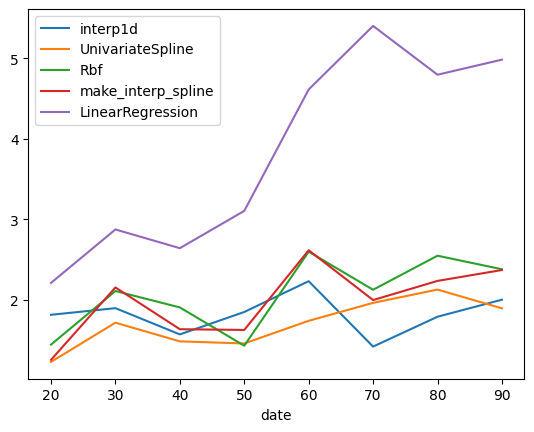

In [48]:
df.index.name = 'date'
df.to_csv("./mask.csv")
sns.lineplot(data=df[-200:],dashes=False)
# sns.lineplot(data=Risk_Table[-200:],dashes=False)
plt.show()

In [22]:
prices = pd.read_csv("../data/Stock/stock.csv", index_col=0)
# length = [100, 200, 500, 1000, 2000]
Risk_Table = pd.DataFrame(columns=prices.columns)
import ffn
for l in tqdm(range(10, 1000, 5)):
    test = prices.iloc[-l:]
    Dnext = test[ 1:].reset_index(drop=True)
    Dthis = test[:-1].reset_index(drop=True)
    Risk_each_day = (Dnext - Dthis)**2
    Risk_square = Risk_each_day.sum(axis=0)/test.shape[0]
    Risk = Risk_square**(1/2)
    Risk.name = f"{l}"
    Risk_Table = pd.concat([Risk_Table, Risk.to_frame().T])
print(Risk_Table)

100%|██████████| 198/198 [00:00<00:00, 1021.33it/s]

         meta      goog      amzn       nflx      aapl
10   3.579025  2.123370  3.096448   8.710280  3.715992
15   3.368478  1.912816  2.956958   7.805025  3.270748
20   4.694950  2.260889  3.470419   8.514154  3.743773
25   4.474528  2.185165  3.324596   8.172609  3.641109
30   4.381730  2.053572  3.073591   7.643565  3.418511
..        ...       ...       ...        ...       ...
975  6.156269  1.834748  2.903207  11.636690  2.321580
980  6.148713  1.831520  2.899405  11.620413  2.317740
985  6.135143  1.827927  2.895984  11.606952  2.314115
990  6.121468  1.824858  2.894925  11.599363  2.312011
995  6.113468  1.823834  2.904742  11.608948  2.307105

[198 rows x 5 columns]


In [23]:
# Risk_Table.index.name = 'date'
Risk_Table = Risk_Table.rolling(5).mean()
print(Risk_Table)
sns.lineplot(data=Risk_Table,dashes=False)
plt.gca().invert_xaxis()

         meta      goog      amzn       nflx      aapl
10        NaN       NaN       NaN        NaN       NaN
15        NaN       NaN       NaN        NaN       NaN
20        NaN       NaN       NaN        NaN       NaN
25        NaN       NaN       NaN        NaN       NaN
30   4.099742  2.107163  3.184402   8.169127  3.558027
..        ...       ...       ...        ...       ...
975  6.180033  1.840398  2.903327  11.660157  2.331454
980  6.170529  1.837293  2.902139  11.647496  2.326735
985  6.158296  1.834252  2.900582  11.633951  2.322251
990  6.146173  1.831365  2.899435  11.623054  2.318463
995  6.135012  1.828577  2.899653  11.614473  2.314510

[198 rows x 5 columns]


In [24]:

Risk_Table.to_csv("./risk.csv")

In [24]:
print(output)

{10: {'meta': 1.6196800643944362, 'goog': 1.2673162125859558, 'amzn': 1.597083707857153, 'nflx': 1.986006031051689, 'aapl': 1.4632982919625004}}


In [ ]:
# SDM stock_data_masked
mask_percent = 0.3
title = SD.columns
SD = SD.to_numpy()
SDM = SD.copy()

MASK = np.random.choice([True, False], size=SDM.shape, p=[mask_percent, 1-mask_percent])
MASK[0, :] = MASK[-1, :] = False
SDM = np.ma.masked_array(SDM, mask=MASK)

model = LinearRegression()
inter_func = {"interp1d": interp1d,
              "UnivariateSpline" : UnivariateSpline, 
              "Rbf" : Rbf, 
              "make_interp_spline" : make_interp_spline,
              "LinearRegression": model}
stock_avg = np.mean(SD, axis=0)